**Course website**: https://github.com/leomiquelutti/UFU-geofisica-1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade Federal de Uberlândia](http://www.ufu.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Agradecimentos especiais ao [Leonardo Uieda](www.leouieda.com)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Gravimetria - Interpolação, mapas e a gravidade da Terra

## Objetivos

* Entender a influência da interpolação na geração de mapas de dados geofísicos
* Visualizar as variações geográficas da gravidade da Terra
* Entender como a escala de cores utilizada nos mapas influencia nossa interpretação
* Aprender quais são os fatores que devem ser considerados quando visualizamos um dado em mapa

## Instruções

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

Para executar uma célula, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

## Preparação

Exectute as células abaixo para carregar as componentes necessárias para nossa prática. Vamos utilizar várias *bibliotecas*, inclusive uma de geofísica chamada [Fatiando a Terra](http://www.fatiando.org).

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from IPython.display import display
import seaborn
from fatiando import utils, gridder
import fatiando
from icgem import load_icgem_gdf, down_sample

In [2]:
print("Usando a versão do Fatiando a Terra: {}".format(fatiando.__version__))

Usando a versão do Fatiando a Terra: 0.5


## Interpolação

O melhor jeito de entendermos o efeito da interpolação é fabricando alguns dados fictícios (sintéticos).
Assim, podemos gerar os dados tanto em pontos aleatórios quanto em um grid regular.
Isso nos permite comparar os resultados da interpolação com o *verdadeiro*. Nosso verdadeiro será um conjunto de dados medidos em um grid regular. Como se tivéssemos ido ao campo e medido em um grid regular.

Rode a célula abaixo para gerar os dados em pontos aleatórios e em um grid regular.

In [3]:
area = (-5000., 5000., -5000., 5000.)
shape = (100, 100)
xp, yp = gridder.scatter(area, 100, seed=6)
x, y = [i.reshape(shape) for i in gridder.regular(area, shape)]
aletatorio = 50*utils.gaussian2d(xp, yp, 10000, 1000, angle=45)
regular = 50*utils.gaussian2d(x, y, 10000, 1000, angle=45).reshape(shape)

Rode as duas células abaixo para gerar um gráfico interativo. Nesse gráfico você poderá controlar:

* O número de pontos (em x e y) do grid utilizado na interpolação (`num_pontos`)
* O método de interpolação utilizado (`metodo`). Pode ser interpolação cúbica ou linear.
* Mostrar ou não os pontos de medição aleatórios no mapa interpolado.

**Repare no que acontece com as bordas do mapa e onde não há observações**.

In [4]:
def interpolacao(num_pontos, metodo, pontos_medidos):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ishape = (num_pontos, num_pontos)
    tmp = gridder.interp(yp, xp, aletatorio, ishape, area=area, algorithm=metodo, extrapolate=True)
    yi, xi, interp = [i.reshape(ishape) for i in tmp]
    ranges = np.abs([interp.min(), interp.max()]).max()
    kwargs = dict(cmap="RdBu_r", vmin=-ranges, vmax=ranges)
    ax = axes[0]
    ax.set_title(u'Pontos medidos')
    ax.set_aspect('equal')
    tmp = ax.scatter(yp*0.001, xp*0.001, s=80, c=aletatorio, **kwargs)
    plt.colorbar(tmp, ax=ax, aspect=50, pad=0.01)
    ax.set_xlabel('y (km)')
    ax.set_ylabel('x (km)')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    plt.tight_layout(pad=0)
    ax = axes[1]
    ax.set_title(u'Interpolado')
    ax.set_aspect('equal')
    tmp = ax.contourf(yi*0.001, xi*0.001, interp, 40, **kwargs)
    plt.colorbar(tmp, ax=ax, aspect=50, pad=0.01)
    if pontos_medidos:
        ax.plot(yp*0.001, xp*0.001, '.k')
    ax.set_xlabel('y (km)')
    ax.set_ylabel('x (km)')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    plt.tight_layout(pad=0)

In [5]:
w = widgets.interactive(interpolacao, num_pontos=(5, 100, 5), metodo=['cubic', 'linear'], pontos_medidos=False)
display(w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01MCwgZGVzY3JpcHRpb249dSdudW1fcG9udG9zJywgbWluPTUsIHN0ZXA9NSksIERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnbWXigKY=


Vamos verificar se alguma das combinações chegou perto do resultado *verdadeiro*.

Rode a célula abaixo para gerar um gráfico dos dados verdadeiros (gerados em um grid regular). Esse deveria ser o resultado observado se a interpolação fosse perfeita.

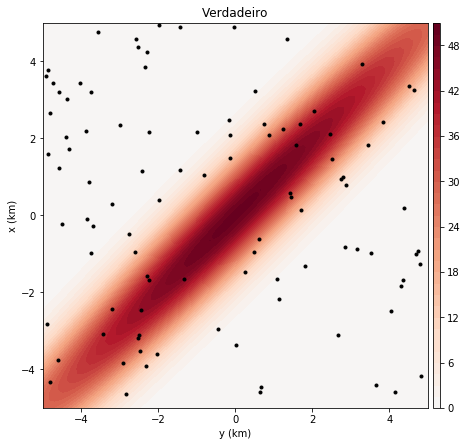

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ranges = np.abs([regular.min(), regular.max()]).max()
kwargs = dict(cmap="RdBu_r", vmin=-ranges, vmax=ranges)
ax.set_title(u'Verdadeiro')
ax.set_aspect('equal')
tmp = ax.contourf(y*0.001, x*0.001, regular, 40, **kwargs)
plt.colorbar(tmp, ax=ax, aspect=50, pad=0.01)
ax.plot(yp*0.001, xp*0.001, '.k')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')
plt.tight_layout(pad=0)

# Gravidade do mundo

Vamos visualizar como a gravidade da Terra varia geograficamente. Os dados da gravidade do mundo foram baixados de http://icgem.gfz-potsdam.de/ICGEM/potato/Service.html usando o modelo EIGEN-6c3stat.

**As medições foram feitas em cima da superfície da Terra**, ou seja, acompanhando a topografia.

Rode as células abaixo para carregar os dados.

In [7]:
dados = load_icgem_gdf('data/eigen-6c3stat-0_5-mundo.gdf')

In [8]:
lat, lon, grav = dados['latitude'], dados['longitude'], dados['gravity_earth']

Vamos fazer um mapa da gravidade utilizando a [projeção Mollweid](http://en.wikipedia.org/wiki/Map_projection). Esses dados estão em mGal: 1 mGal = 10⁻⁵ m/s². 

Rode as duas células abaixo para gerar o gráfico (isso pode demorar um pouco).

In [10]:
bm = Basemap(projection='moll', lon_0=0, resolution='c')
x, y = bm(lon, lat)

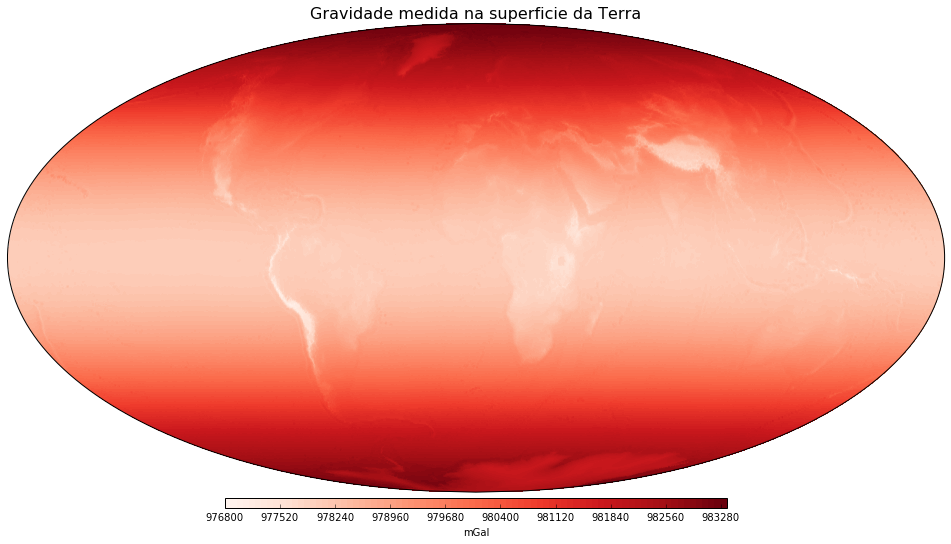

In [11]:
plt.figure(figsize=(18, 10))
tmp = bm.contourf(x, y, grav, 100, tri=True, cmap='Reds')
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, shrink=0.5).set_label('mGal')
plt.title("Gravidade medida na superficie da Terra", fontsize=16)

## Escala de cor

A escala de cores que utilizamos para mapear os valores pode ter um impacto grande na nossa interpretação dos resultados. Abaixo, veremos como o nosso dado de gravidade mundial fica quando utilizamos diferentes escalas de cor.

As escalas podem ser divididas em 3 categorias:

* lineares: as cores variam de um tom claro (geralmente branco) a uma cor (por exemplo, vermelho) de maneira linear
* divergente: as cores variam de uma cor escura, passando por um tom claro (geralmente branco), e depois para outra cor escura.
* raindow ou qualitativos: as cores variam sem um padrão de intensidade claro. Podem ser as cores do arco-íris ou outra combinação.

Nas escalas lineares e divergentes, as cores sempre variam de baixa intensidade para alta intensidade (e vice-versa para escalas divergentes).

Rode as células abaixo para gerar um mapa interativo da gravidade mundial. Você poderá controlar qual escala de cor você quer usar. Experimente com elas e veja como elas afetam sua percepção.

**Para pensar**: Como isso pode afetar alguem que é [daltônico](https://pt.wikipedia.org/wiki/Daltonismo)?

In [12]:
def grav_mundial(escala_de_cor):
    plt.figure(figsize=(18, 10))
    tmp = bm.contourf(x, y, grav, 100, tri=True, cmap=escala_de_cor)
    plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, shrink=0.5).set_label('mGal')
    plt.title("Escala de cor: {}".format(escala_de_cor), fontsize=16)  

In [13]:
escalas = 'Reds Blues Greys YlOrBr RdBu BrBG PRGn Dark2 jet ocean rainbow gnuplot'.split()
w = widgets.interactive(grav_mundial, escala_de_cor=escalas)
display(w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZXNjYWxhX2RlX2NvcicsIG9wdGlvbnM9KCdSZWRzJywgJ0JsdWVzJywgJ0dyZXlzJywgJ1lsT3JCcicsICdSZELigKY=


[]()